Final Project Notebook

In [576]:
#imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns

In [577]:
#reading in the data
train_data = pd.read_csv('../data/train.csv')
print(train_data.head())

         id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
0  00008ff9                      Fall                5                0   
1  000fd460                    Summer                9                0   
2  00105258                    Summer               10                1   
3  00115b9f                    Winter                9                0   
4  0016bb22                    Spring               18                1   

  CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  Physical-Height  \
0      Winter             51.0            Fall     16.877316             46.0   
1         NaN              NaN            Fall     14.035590             48.0   
2        Fall             71.0            Fall     16.648696             56.5   
3        Fall             71.0          Summer     18.292347             56.0   
4      Summer              NaN             NaN           NaN              NaN   

   Physical-Weight  ...  PCIAT-PCIAT_18  PCIAT-PCIAT_19  PCIAT

In [578]:
#optional filtering
#train_data = train_data[train_data['Basic_Demos-Age'] >= 8]
#optional conversion to binary classification
train_data.loc[train_data['sii'] != 0, 'sii'] = 1

In [579]:
#EDA
print("Shape of data:", train_data.shape)

print("Target variable value counts:", train_data['sii'].value_counts())

clean_train_data = train_data.dropna(subset=['sii'])
print("Shape after dropping NaN sii values from target variable:", clean_train_data.shape)

print("Column Names:", clean_train_data.columns)


Shape of data: (3960, 82)
Target variable value counts: sii
1.0    2366
0.0    1594
Name: count, dtype: int64
Shape after dropping NaN sii values from target variable: (3960, 82)
Column Names: Index(['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
       'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
       'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
       'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI'

(array([ 61.,   0., 254., 702., 569., 365., 309., 260., 196., 120.,  86.,
         50.,  34.,  18.,  21.,  17.,   7.,   1.,   2.,   4.]),
 array([  0.  ,  15.75,  31.5 ,  47.25,  63.  ,  78.75,  94.5 , 110.25,
        126.  , 141.75, 157.5 , 173.25, 189.  , 204.75, 220.5 , 236.25,
        252.  , 267.75, 283.5 , 299.25, 315.  ]),
 <BarContainer object of 20 artists>)

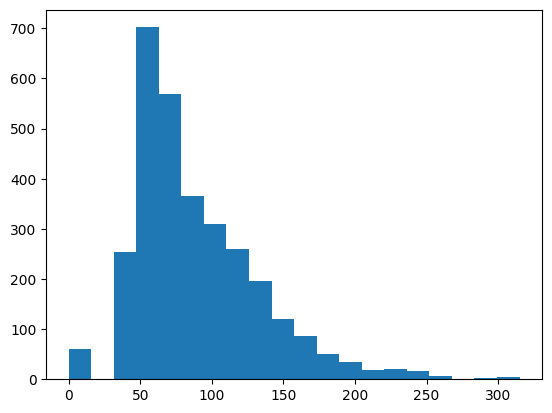

In [580]:
#picture EDA
plt.hist(clean_train_data['Physical-Weight'], bins=20)

In [581]:
#Pure Baseline
majority_class = 0
print(1594 / (1594 + 730 + 378 + 34))
clean_train_data[clean_train_data['sii'] == 0].shape[0] / clean_train_data.shape[0]

0.5826023391812866


0.4025252525252525

PAQ_A-PAQ_A_Total              88.0
PAQ_A-Season                   88.0
Fitness_Endurance-Time_Sec     81.3
Fitness_Endurance-Time_Mins    81.3
Fitness_Endurance-Max_Stage    81.2
                               ... 
id                              0.0
Basic_Demos-Enroll_Season       0.0
Basic_Demos-Sex                 0.0
Basic_Demos-Age                 0.0
sii                             0.0
Length: 82, dtype: float64


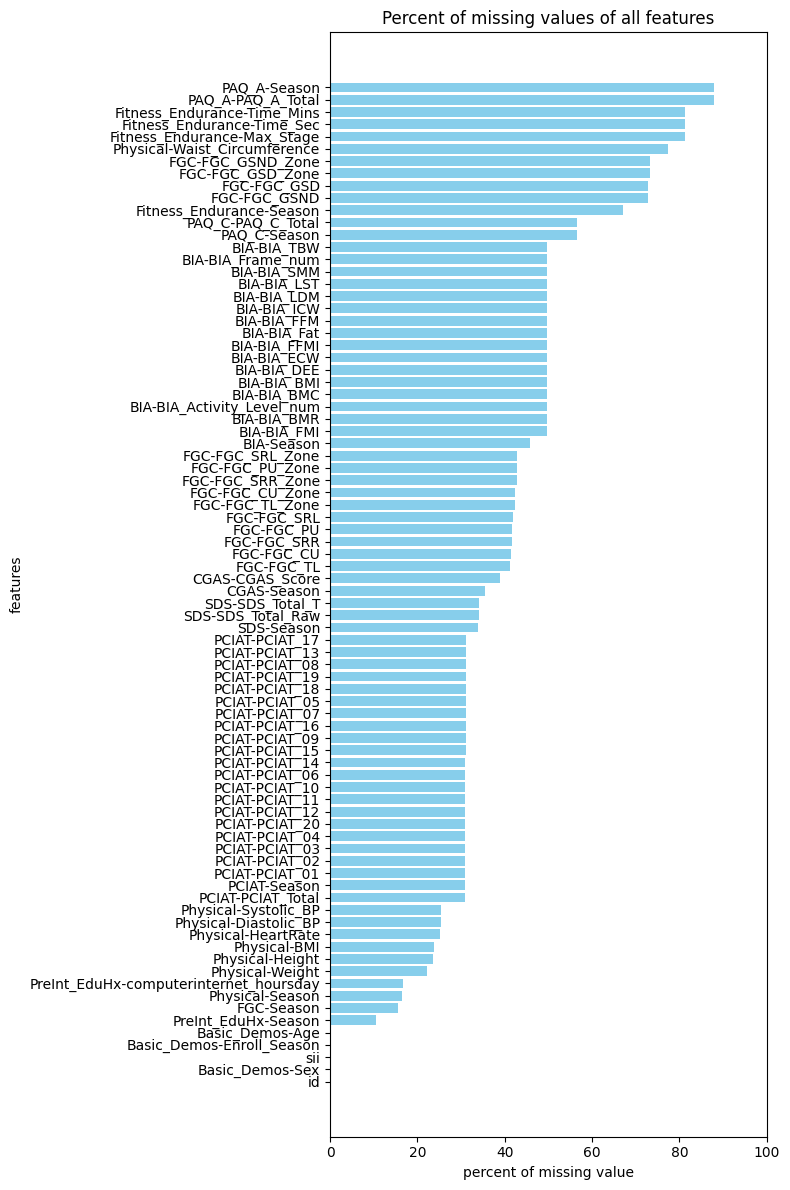

In [582]:
#drop columns that have a lot of missing values

# Check missing values
# Check missing values
missing_values = clean_train_data.isnull().sum()
missing_percent= round(clean_train_data.isnull().mean() *100,1)
print(missing_percent.sort_values(ascending=False))
missing_percent_df = pd.DataFrame(
    {'feature': missing_percent.index,
     'missing_percent': missing_percent.values})
missing_percent_df = missing_percent_df.sort_values(by = 'missing_percent', ascending = True)
# Plot bar chart of missing values by features
plt.figure(figsize = (8,12)) # set figure size
plt.barh(missing_percent_df['feature'], missing_percent_df['missing_percent'],color = 'skyblue') # plot vertical bar chart
plt.xlabel("percent of missing value")
plt.ylabel("features")
plt.title("Percent of missing values of all features")
plt.xlim(0,100)
plt.tight_layout()
plt.show()

missing_percent_df = missing_percent_df[missing_percent_df['missing_percent']>=100].sort_values(by='missing_percent',ascending = False).reset_index(drop = True)
missingvalue_cols = missing_percent_df['feature'].tolist()
clean_train_data = clean_train_data.drop(columns = missingvalue_cols)

In [583]:
# address missing values in X_train
for col in clean_train_data:
    if clean_train_data[col].dtype == 'object':
       clean_train_data[col].fillna('missing', inplace = True)
    else:
       clean_train_data[col].fillna(0,inplace = True)

C:\Users\18186\AppData\Local\Temp\ipykernel_13300\2144376134.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clean_train_data[col].fillna('missing', inplace = True)
C:\Users\18186\AppData\Local\Temp\ipykernel_13300\2144376134.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



In [584]:
#get data features numeric and non numeric
categorical_columns = ['Basic_Demos-Enroll_Season',
'Basic_Demos-Sex',
'CGAS-Season',
'Physical-Season',
'Fitness_Endurance-Season',
'FGC-Season',
'FGC-FGC_CU_Zone',
'FGC-FGC_GSND_Zone',
'FGC-FGC_GSD_Zone',
'FGC-FGC_PU_Zone',
'FGC-FGC_SRL_Zone',
'FGC-FGC_SRR_Zone',
'FGC-FGC_TL_Zone',
'BIA-Season',
'BIA-BIA_Activity_Level_num',
'BIA-BIA_Frame_num',
'PAQ_A-Season',
'PAQ_C-Season',
'SDS-Season',
'PreInt_EduHx-Season',
'PreInt_EduHx-computerinternet_hoursday']


# List of columns to remove
#columns_to_remove = ['Fitness_Endurance-Season', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'PAQ_A-Season', 'PAQ_C-Season']
#columns_to_remove = ['BIA-BIA_Frame_num', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'PreInt_EduHx-computerinternet_hoursday']
columns_to_remove = ['BIA-BIA_Frame_num', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'PreInt_EduHx-computerinternet_hoursday', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'PAQ_A-Season']
#columns_to_remove = ['FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'PAQ_A-Season']
# Remove columns by filtering them out
categorical_columns = [col for col in categorical_columns if col not in columns_to_remove]


encoder = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False)
X_train_encoded = encoder.fit_transform (clean_train_data[categorical_columns])
X_train_enc = pd.DataFrame(X_train_encoded, columns = encoder.get_feature_names_out(categorical_columns))
X_val_encoded = encoder.transform(clean_train_data[categorical_columns])
X_val_enc = pd.DataFrame(X_val_encoded, columns = encoder.get_feature_names_out(categorical_columns))

print(X_train_enc)

      Basic_Demos-Enroll_Season_Fall  Basic_Demos-Enroll_Season_Spring  \
0                                1.0                               0.0   
1                                0.0                               0.0   
2                                0.0                               0.0   
3                                0.0                               0.0   
4                                0.0                               1.0   
...                              ...                               ...   
3955                             1.0                               0.0   
3956                             0.0                               0.0   
3957                             1.0                               0.0   
3958                             0.0                               1.0   
3959                             0.0                               1.0   

      Basic_Demos-Enroll_Season_Summer  Basic_Demos-Enroll_Season_Winter  \
0                                  

In [585]:
#First Baseline Model

# Split the data into training and testing sets
#X = clean_train_data[['Basic_Demos-Age', 'Basic_Demos-Sex', 'Physical-BMI', 'Physical-Weight', 'Physical-Height', 'CGAS-CGAS_Score', 'Physical-HeartRate' ]]
def getFeatures():
    columns_to_drop = categorical_columns.copy()
    columns_to_drop = categorical_columns + ['sii', 'id'] + ['PCIAT-Season', 'PCIAT-PCIAT_01','PCIAT-PCIAT_02','PCIAT-PCIAT_03','PCIAT-PCIAT_04','PCIAT-PCIAT_05','PCIAT-PCIAT_06','PCIAT-PCIAT_07',
'PCIAT-PCIAT_08','PCIAT-PCIAT_09','PCIAT-PCIAT_10','PCIAT-PCIAT_11','PCIAT-PCIAT_12','PCIAT-PCIAT_13','PCIAT-PCIAT_14','PCIAT-PCIAT_15','PCIAT-PCIAT_16','PCIAT-PCIAT_17',
'PCIAT-PCIAT_18','PCIAT-PCIAT_19','PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total']
    X = pd.concat([clean_train_data.drop(columns=columns_to_drop).reset_index(drop=True), X_train_enc.reset_index(drop=True)], axis=1)
    return X
X = getFeatures()

X = X[['SDS-SDS_Total_Raw', 'Physical-Systolic_BP', 'Basic_Demos-Age', 'Physical-Diastolic_BP', 'Physical-Height', 'Physical-HeartRate', 'Physical-BMI', 'PAQ_C-PAQ_C_Total', 'CGAS-CGAS_Score', 'Physical-Weight']]

# X = X[['BIA-BIA_BMI',
# 'BIA-BIA_FFMI',
# 'BIA-BIA_Frame_num',
# 'Basic_Demos-Age',
# 'FGC-FGC_CU',
# 'FGC-FGC_PU',
# 'FGC-FGC_SRL_Zone',
# 'FGC-FGC_SRR_Zone',
# 'FGC-FGC_TL',
# #'PAQ_A-Season',
# #'PAQ_C-Season',
# 'Physical-Height',
# 'Physical-Systolic_BP',
# 'Physical-Weight',
# 'PreInt_EduHx-computerinternet_hoursday',
# 'SDS-SDS_Total_T']]

#X = clean_train_data[['SDS-SDS_Total_T', 'Physical-Height']]

#Train test split
X_trainval, X_test, Y_trainval, y_test = train_test_split(X, clean_train_data['sii'], test_size= 0.2, random_state=1234) #set seed

# Split into train and val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, Y_trainval, test_size= 0.25, random_state=1234)  # 0.25 x 0.8 = 0.2

#EDA
print(X_train.shape)
print(y_train.value_counts())
print(y_val.shape)
print(y_val.value_counts())

#standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

# Initialize the RandomForestClassifier model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model using the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = rf_classifier.predict(X_val)

# Step 7: Evaluate the model's performance
print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

# Feature importance 
feature_importances = pd.DataFrame(rf_classifier.feature_importances_,
                                   index=X.columns,
                                   columns=["Importance"]).sort_values("Importance", ascending=False)

print("\nFeature Importances:\n", feature_importances)

(2376, 10)
sii
1.0    1410
0.0     966
Name: count, dtype: int64
(792,)
sii
1.0    480
0.0    312
Name: count, dtype: int64
Accuracy: 0.7512626262626263

Classification Report:
               precision    recall  f1-score   support

         0.0       0.68      0.70      0.69       312
         1.0       0.80      0.78      0.79       480

    accuracy                           0.75       792
   macro avg       0.74      0.74      0.74       792
weighted avg       0.75      0.75      0.75       792


Feature Importances:
                        Importance
SDS-SDS_Total_Raw        0.217054
CGAS-CGAS_Score          0.113601
Physical-Height          0.110051
Physical-Weight          0.108536
Basic_Demos-Age          0.093839
Physical-BMI             0.090052
Physical-HeartRate       0.073741
Physical-Systolic_BP     0.072544
Physical-Diastolic_BP    0.067703
PAQ_C-PAQ_C_Total        0.052879


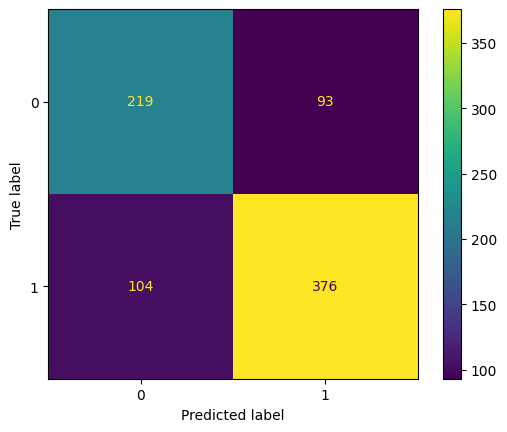

In [586]:
#Analyze Results with Confusion Matrix
m = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(m).plot()

Neural Network

In [587]:
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01,
                metric='metric'):
    """Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.
    metric: The desired metric.

    Returns:
    model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)


    model = tf.keras.Sequential()
    #model.add(tf.keras.layers.Flatten())

    for hidden_layer_size in hidden_layer_sizes:
      model.add(tf.keras.layers.Dense(units=hidden_layer_size,
                                      activation=activation))
    model.add(tf.keras.layers.Dense(units=n_classes, activation='softmax'))

    # Choose the optimizer based on the input
    if optimizer == 'SGD':
        optimizer_instance = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'Adam':
        optimizer_instance = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer_instance, metrics=[metric])

    return model

[0. 1.]
[0. 1.]
{0: 1.2298136645962734, 1: 0.8425531914893617}
Epoch 1/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3094 - loss: 1.3770 - val_accuracy: 0.6263 - val_loss: 1.0295
Epoch 2/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6556 - loss: 0.9665 - val_accuracy: 0.6995 - val_loss: 0.7882
Epoch 3/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6988 - loss: 0.7683 - val_accuracy: 0.7159 - val_loss: 0.6768
Epoch 4/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7075 - loss: 0.6770 - val_accuracy: 0.7235 - val_loss: 0.6181
Epoch 5/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7067 - loss: 0.6278 - val_accuracy: 0.7260 - val_loss: 0.5818
Epoch 6/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7075 - loss: 0.5968 - val_accuracy: 0.7298 - val_loss: 0.5571
Epoch 7/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7073 - loss: 0.5748 - val_accuracy: 0.7386 - val_loss: 0.5393
Epoch 8/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

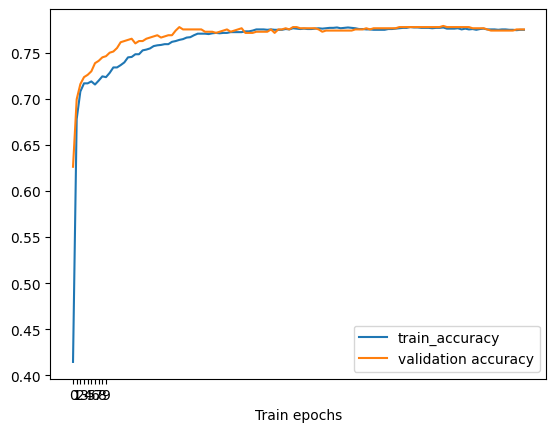

Training accuracy: 0.7748
Validation accuracy: 0.7753


In [588]:
model = build_model(n_classes=4,
                      hidden_layer_sizes=[20],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.001,
                       metric='accuracy')

# Assuming y_train contains the class labels
print(np.unique(y_train))
print(np.unique(y_val))
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
#class_weight_dict = {0: 0.42734375, 1: 0.9345102505694761, 2: 1.8647727272727272, 3: 8.647727272727273}
print(class_weight_dict)

#early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(x=X_train, y=np.array(y_train), epochs=500,
        batch_size=64,
        validation_data=(X_val, y_val),
        verbose=1,
        #class_weight=class_weight_dict,
        callbacks=[early_stopping])

# Retrieve the training metrics (after each train epoch) and the final validation
    # accuracy.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(10))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

print('Training accuracy: %1.4f' %train_accuracy[-1])
print('Validation accuracy: %1.4f' %val_accuracy[-1])

(2376,)
(2376,)


Accuracy: 0.8481
Accuracy: 0.7513


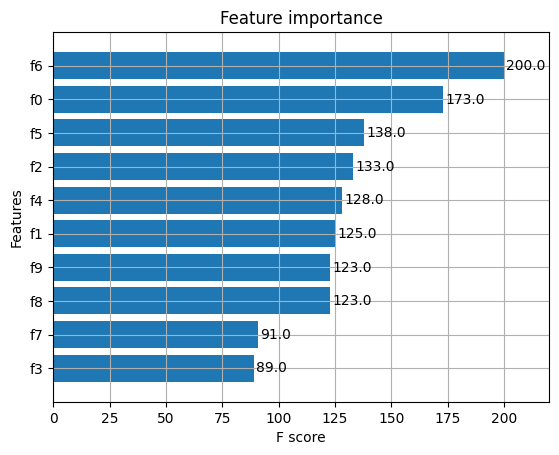

f6    200.0
f0    173.0
f5    138.0
f2    133.0
f4    128.0
f1    125.0
f8    123.0
f9    123.0
f7     91.0
f3     89.0
dtype: float64


In [589]:
#XGBoost
# Initialize and train the XGBoost model
model = xgb.XGBClassifier(
    objective='multi:softmax',  # Multi-class classification
    num_class=4,                # Number of classes in target
    eval_metric='mlogloss',      # Multi-class log loss
    use_label_encoder=False,    # Avoid label encoder warning
    learning_rate=0.01,          # Learning rate
    max_depth=4,                # Depth of trees
    n_estimators=1000,           # Number of boosting rounds (trees)
    subsample=0.8,              # Fraction of samples used per tree
    colsample_bytree=0.8,       # Fraction of features used per tree
    seed=1234                     # Random seed for reproducibility
)

params = {'max_depth': 3, 'n_estimators': 202, 'learning_rate': 0.07956777025142073, 'subsample': 0.8197358255094112, 'colsample_bytree': 0.645036755035947}
model = xgb.XGBClassifier(**params)

# Fit the model
print(y_train.shape)
#y_train[y_train != 0] = 1
#y_val[y_val != 0] = 1
print(y_train.shape)
model.fit(X_train, y_train)

# Make predictions on the train set
y_pred = model.predict(X_train)

# Evaluate the model accuracy
accuracy = accuracy_score(y_train, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Make predictions on the val set
y_pred = model.predict(X_val)

# Evaluate the model accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Plot feature importance
xgb.plot_importance(model, importance_type='weight', max_num_features=10, height=0.8)
plt.show()

# Assuming you have a list of feature names (e.g., from X_train's columns)
#print(X_train.columns)
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f'f{i}' for i in range(X_train.shape[1])]

# Get the feature importances
importance = model.get_booster().get_score(importance_type='weight')

# Map feature importances to the actual feature names
importance_df = pd.Series(importance).sort_values(ascending=False)
importance_df.index = [feature_names[int(i[1:])] for i in importance_df.index]

# Print the sorted feature importances with actual names
print(importance_df)

(2376, 10)


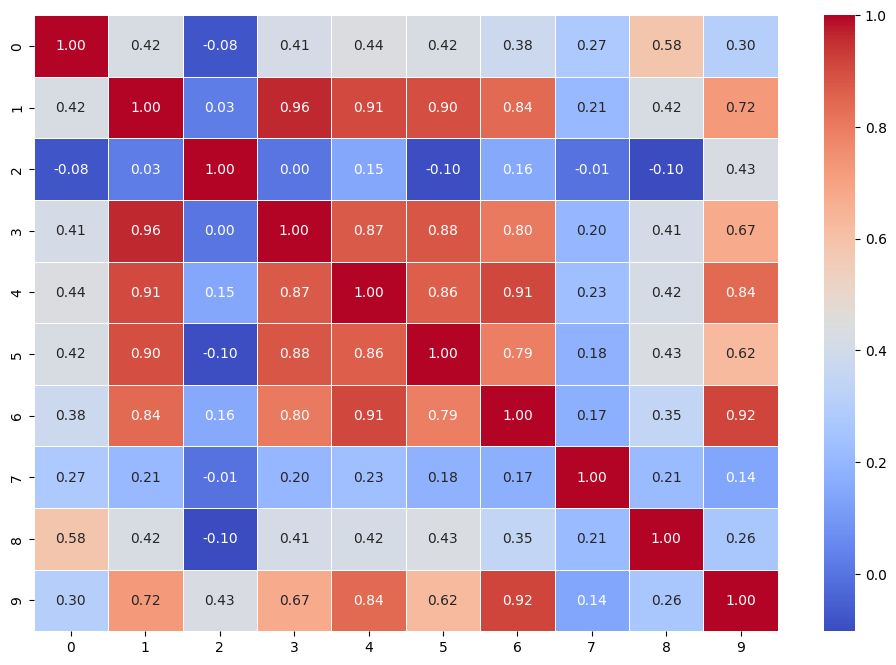

(2376, 0)


In [590]:
#Feature Analysis
# Calculate the correlation matrix
X_train_df = pd.DataFrame(X_train)
print(X_train_df.shape)
corr_matrix = X_train_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.show()

# Remove highly correlated features (threshold > 0.9)
to_drop = [column for column in corr_matrix.columns if any(corr_matrix[column] > 0.9)]
X_train_reduced = X_train_df.drop(columns=to_drop)
print(X_train_reduced.shape)
#X_val_reduced = X_val.drop(columns=to_drop)